# Introduction to Spark Streaming

_____
### Note on  Streaming
Streaming is something that is rapidly advancing and changing fast, there are multiple new libraries every year, new and different services always popping up, and what is in this notebook may or may not apply to you. Maybe your looking for something specific on Kafka, or maybe you are looking for streaming about twitter, in which case Spark might be overkill for what you really want. Realistically speaking each situation is going to require a customized solution and this course is never going to be able to supply a one size fits all solution. Because of this, I wanted to point out some great resources for Python and Spark Streaming

* [The Official Documentation is great. This should be your first go to.](http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide)

* [Fantastic Guide to Spark Streaming with Kafka](https://www.rittmanmead.com/blog/2017/01/getting-started-with-spark-streaming-with-python-and-kafka/)

* [Another Spark Streaming Example with Geo Plotting](http://nbviewer.jupyter.org/github/ibm-cds-labs/spark.samples/blob/master/notebook/DashDB%20Twitter%20Car%202015%20Python%20Notebook.ipynb)
____

Spark has pretty well known Streaming Capabilities, if streaming is something you've found yourself needing at work then you are probably familiar with some of these concepts already, in which case you may find it more useful to jump straight to the official documentation here:

http://spark.apache.org/docs/latest/streaming-programming-guide.html#spark-streaming-programming-guide

It is really a great guide, but keep in mind some of the features are restricted to Scala at this time (Spark 2.1), hopefully they will be expanded to the Python API in the future!

For those of you new to Spark Streaming, let's get started with a classic example, streaming Twitter! Twitter is a great source for streaming because its something most people already have an intuitive understanding of, you can visit the site yourself, and a lot of streaming technology has come out of Twitter as a company. You don't access to the entire "firehose" of twitter without paying for it, but that would be too much for us to handle anyway, so we'll be more than fine with the freely available API access.

_____

Let's discuss SparkStreaming!

Spark Streaming is an extension of the core Spark API that enables **scalable, high-throughput, fault-tolerant** stream processing of live data streams. Data can be ingested from many sources like Kafka, Flume, Kinesis, or TCP sockets, and can be processed using complex algorithms expressed with high-level functions like map, reduce, join and window. Finally, processed data can be pushed out to filesystems, databases, and live dashboards. In fact, you can apply Spark’s machine learning and graph processing algorithms on data streams.

<img src='http://spark.apache.org/docs/latest/img/streaming-arch.png'/>

Keep in mind that a few of these Streamiing Capabilities are limited when it comes to Python, you'll need to reference the documentation for the most up to date information. Also the streaming contexts tend to follow more along with the older RDD syntax, so a few things might seem different than what we are used to seeing, keep that in mind, you'll definitely want to have a good understanding of lambda expressions before continuing with this!

There are SparkSQL modules for streaming: 

http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=streaming#module-pyspark.sql.streaming

But they are all still listed as experimental, so instead of showing you somethign that might break in the future, we'll stick to the RDD methods (which is what the documentation also currently shows for streaming).

Internally, it works as follows. Spark Streaming receives live input data streams and divides the data into batches, which are then processed by the Spark engine to generate the final stream of results in batches.

<img src='http://spark.apache.org/docs/latest/img/streaming-flow.png'/>

## Simple Local Example

We'll do a simple local counting example, make sure to watch the video for this, the example will only work on Linux type systems, not on a Windows computer. This makes sense because you won't run this on Windows in the real world. Definitely watch the video for this one, a lot of it can't be replicated on Jupyter Notebook by itself!

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

# Create a local StreamingContext with two working thread and batch interval of 1 second
sc = SparkContext("local[2]", "NetworkWordCount") # "local[2]" means using two local threads
ssc = StreamingContext(sc, 1)

In [2]:
# Create a DStream that will connect to hostname:port, like localhost:9999
# Firewalls might block this!
lines = ssc.socketTextStream("localhost", 9999)

In [3]:
# Split each line into words
words = lines.flatMap(lambda line: line.split(" "))

In [4]:
# Count each word in each batch
pairs = words.map(lambda word: (word, 1))
wordCounts = pairs.reduceByKey(lambda x, y: x + y)

# Print the first ten elements of each RDD generated in this DStream to the console
wordCounts.pprint()

Now we open up a Unix terminal and type:

         $ nc -lk 9999
     $ hello world any text you want
     
With this running run the line below, then type Ctrl+C to terminate it.

In [ ]:
ssc.start() # Start the computation
ssc.awaitTermination()  # Wait for the computation to terminate

-------------------------------------------
Time: 2019-10-18 12:49:46
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:49:47
-------------------------------------------
('i', 1)
('am', 1)
('allen', 1)
('xiao', 1)
('is', 1)
('interesting', 1)
('there', 1)
('further', 1)
('info?', 1)
('hello', 1)
...

-------------------------------------------
Time: 2019-10-18 12:49:48
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:49:49
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:49:50
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:49:51
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:49:52
-------------------------------------------

-------------------------------------------
Time: 2019-10-18 12:

# Twitter Example
In order to use all of this though, we need to setup a Developer API acocunt with Twitter and create an application to get credentials. Review the video for instructions on how to do this or if you are already familiar with it, just get the credentials from: 

    https://apps.twitter.com/
    
Once you have that you also need to install python-twitter, a python library to connect your Python to the twitter dev account.

You probably won't be able to run this example and then previous in the same notebook, you need to restart you kernel.

Let's get started!

Begin by running the TweetRead.py file. Make sure to add your own IP Adress and your credential keys.

In [1]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [3]:
ssc = StreamingContext(sc, 10) # 10 is batchDuration
sqlContext = SQLContext(sc)

In [4]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9999)

In [5]:
lines = socket_stream.window(20) # should be multiple of batchDuration

In [6]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple('Tweet', fields) # count hashtags

In [7]:
# Use Parenthesis for multiple lines or use \.
(lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: (word.lower(), 1) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

__________
### Now run TweetRead.py
__________

In [8]:
ssc.start()

In [9]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline

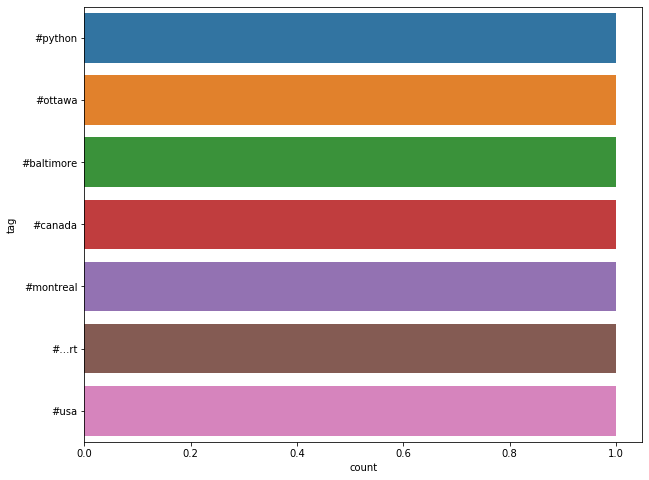

In [10]:
count = 0
while count < 5:
    time.sleep(2) # refresh every 2 seconds
    top_10_tweets = sqlContext.sql('Select tag, count from tweets') # top 10 is because of the limit(10) in the temp view
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = (10, 8))
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [11]:
ssc.stop()